<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Gluc_Wave_Propogation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tifffile
import numpy as np
# from google import colab
import matplotlib
from matplotlib import pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib as mpl
from scipy.signal import butter,filtfilt
import os


In [ ]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [ ]:
def df_trace(trace,ref_inds):
    f0 = np.mean(trace[ref_inds])
    return (trace-f0)/f0

def exp_func(xdata,a,b,c):
    return a*np.exp(xdata/-b) + c

def z_trace(trace):
    std = np.nanstd(trace)
    mean = np.nanmean(trace)
    z_param =  {'std':std, 'mean':mean}
    return (trace-mean)/std, z_param

def bleach_cor(trace,ref_inds,lpf=0.2,order=1):
    b, a = butter(order, lpf, btype='lowpass')
    trace_f = filtfilt(b, a, trace)
    y_fittable = trace_f[ref_inds]
    p0= [np.max(trace), 20000, np.min(trace)]
    min_bound = [0,1000,0]
    max_bound = [np.max(trace)*2,np.inf,np.max(trace)*2]
    p = scipy.optimize.curve_fit(exp_func, ref_inds, y_fittable,p0=p0,bounds=(min_bound,max_bound))
    bleach_trace = exp_func(np.arange(len(trace)), p[0][0], p[0][1], p[0][2])
    trace_corr = trace + (bleach_trace[0] - bleach_trace)    
    return trace_corr, bleach_trace, p[0]

def bleach_cor_PARAM(trace,param):
    bleach_trace = exp_func(np.arange(len(trace)), param[0], param[1], param[2])    
    trace_corr = trace + (bleach_trace[0] - bleach_trace)    
    return trace_corr, bleach_trace, p[0]

def bin_stack(im,bin_factor):
    height = im.shape[1] // bin_factor
    width = im.shape[2] // bin_factor
    im = im[:, :height * bin_factor, : width * bin_factor]
    im = im.reshape(im.shape[0], height, bin_factor, width, bin_factor)
    im = im.sum((2, 4), dtype='uint32')
    return im

def proccess_pxl(trace,ref_inds,df_ind,return_df=True,return_z=True,nan_thresh = 3):
    trace = trace.astype('float32')    
    trace_corr, _, bleach_param = bleach_cor(trace,ref_inds)
    if return_df: trace_corr = df_trace(trace_corr,df_inds)
    if return_z:
        trace_test,_ = z_trace(trace_corr)
        trace_corr[abs(trace_test)>=nan_thresh] = np.nan
        trace_corr[abs(trace_test)<nan_thresh],v = z_trace( trace_corr[abs(trace_test)<nan_thresh] )
#         trace_corr,_ = z_trace(trace_corr)
    return trace_corr, bleach_param

def vec_image(im):
    og_shape = im.shape
    im_vec = np.reshape(im,[og_shape[0],og_shape[1]*og_shape[2]])
    return im_vec, og_shape

def unvec_image(im,og_shape):
    im = np.reshape(im,[og_shape[0],og_shape[1],og_shape[2]])
    return im

def wave_propogation(binary_mov_vec, og_shape,consecutive_window = 10,consecutive_sensitivity=1,last_ind=np.inf):
    conv_filter = np.concatenate( [np.zeros([consecutive_window,1]),np.ones([consecutive_window,1])],axis=0)
    binary_mov_vec = scipy.signal.convolve2d(binary_mov_vec,conv_filter,mode='same')/consecutive_window >= consecutive_sensitivity
    t_vec = np.arange(binary_mov_vec.shape[0])
    inds = np.zeros_like(binary_mov_vec).astype('float64')
    for p in np.arange(binary_mov_vec.shape[1]):
        inds[:,p] = np.multiply(binary_mov_vec[:,p] , t_vec)
    inds = inds.astype('float64')
    inds[inds==0.]=np.nan
    inds[inds>last_ind]=np.nan
    inds = np.nanmin(inds,axis=0)
    inds = unvec_image(inds,[1, og_shape[1],og_shape[2]])
    inds = scipy.ndimage.median_filter(inds,size= 4)
    return inds[0,:,:]

In [ ]:
local_link = os.path.normpath('C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\2023\\May 22\\S1_10Hz_CNT[1-6072_EX0].TIF')
im = tifffile.imread(local_link, maxworkers=6)
im = bin_stack(im,4)
im = scipy.ndimage.gaussian_filter(im, .4, radius = [10,2,2])
im_vec, og_shape = vec_image(im)
ref_image =  np.max(im,axis=0)
tifffile.imwrite('C://Users//dennis.tabuena//Documents//Downloads//Ref_im.TIF', ref_image )

In [ ]:
im_vec =im_vec.astype('float32')
ref_inds= np.concatenate([np.arange(100,1000),np.arange(4980,4999)])
df_inds = np.arange(900,1000)
param_list = np.zeros([3,im_vec.shape[1]])
for pix in tqdm( np.arange(im_vec.shape[1]) ):
    im_vec[:,pix],bleach_param = proccess_pxl(im_vec[:,pix],ref_inds,df_inds)
    param_list[:,pix] = bleach_param
im_unvec = unvec_image(im_vec,og_shape)
tifffile.imwrite('C://Users//dennis.tabuena//Documents//Downloads//BC_file.TIF', im_unvec)

100%|███████████████████████████████████████████████████████████████████████████| 22500/22500 [03:16<00:00, 114.43it/s]


In [ ]:
im_unvec = unvec_image(im_vec,og_shape)
im_unvec = scipy.ndimage.gaussian_filter(im_unvec, .5, radius = [3,3,3])
im_vec, og_shape = vec_image(im_unvec)

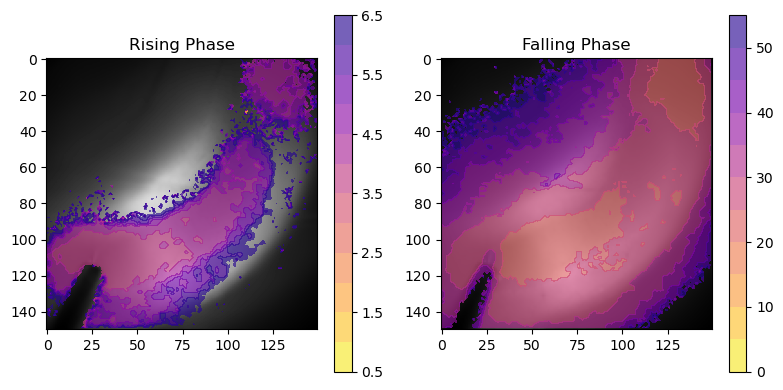

In [ ]:


alpha = 0.63
foi = np.arange(1250,3500)
up_spread_thresh = 1
down_spread_thresh = -1

high_bool = im_vec[foi,:]>up_spread_thresh
low_bool = im_vec[foi,:]<down_spread_thresh

# high_prop = wave_propogation(high_bool, og_shape,last_ind=100)
# low_prop = wave_propogation(low_bool, og_shape)

fig,ax=plt.subplots(1,2,figsize=4*np.array([2,1]))
for a in ax:   
    a.imshow(ref_image,cmap='gray')
    a.set_aspect(ref_image.shape[0]/ref_image.shape[1])

cmap = matplotlib.colormaps.get_cmap('plasma')
cmap = cmap.reversed()

cs=ax[0].contourf((high_prop)/10,cmap=cmap,alpha=alpha,levels = np.arange(0.5,7,0.5))#,levels=levels
ax[0].set_title('Rising Phase')
fig.colorbar(cs,ax=ax[0])

levels = np.arange(0,60,5)
cs=ax[1].contourf((low_prop)/10,cmap=cmap,alpha=alpha,levels=levels)#
ax[1].set_title('Falling Phase')
fig.colorbar(cs,ax=ax[1])
# for a in ax: a.invert_yaxis()
plt.tight_layout()